In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import lmfit
from lmfit import Model
import astropy
import astropy.units as u
import corner
from astropy.cosmology import FlatwCDM

In [2]:
def Hz1(z1,H01,Om1,w01):
    cosmo =FlatwCDM(H0=H01* u.km / u.s / u.Mpc, Om0=Om1,w0=w01) 
    E=cosmo.efunc(z1)
    HZ1 = H01*E
    return HZ1

In [3]:
#Define  random redshifts
num_zs = 1000
zs= np.linspace(0.01,10., num=num_zs)

In [4]:
#From Planck observations
O_m=0.3111
w_0=-1.06
H_0=67.4

In [5]:
#Hubble comoving parameter
Hz=Hz1(zs,H_0,O_m,w_0)/(1+zs)

In [6]:
#random error for Hz
error_sigma = 0.5
e1 = np.random.normal(0., error_sigma, Hz.shape)

In [7]:
H_zz= Hz + e1

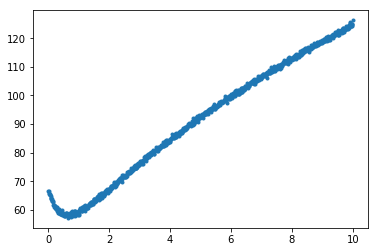

In [8]:
plt.plot(zs,H_zz, '.')

In [13]:
p = lmfit.Parameters()
p.add_many(('Om1',0.3,True,0.,2.),
           ('H01',70.,True,50.,100.),
           ('w01',-1.3,Fal,-3.,-0.3))

def residual(p):
    v = p.valuesdict()
    return (Hz1(zs,v['H01'],v['Om1'],v['w01'])/(1+zs)-H_zz)/error_sigma

In [14]:
mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 1000
    # variables        = 3
    chi-square         = 965.431594
    reduced chi-square = 0.96833660
    Akaike info crit   = -29.1800298
    Bayesian info crit = -14.4567640
[[Variables]]
    Om1:  0.31208100 +/- 0.00117982 (0.38%) (init = 0.3)
    H01:  67.3095335 +/- 0.13002654 (0.19%) (init = 70)
    w01: -1.05555886 +/- 0.00501948 (0.48%) (init = -1.3)
[[Correlations]] (unreported correlations are < 0.100)
    C(Om1, H01) = -0.995
    C(H01, w01) = -0.758
    C(Om1, w01) =  0.725


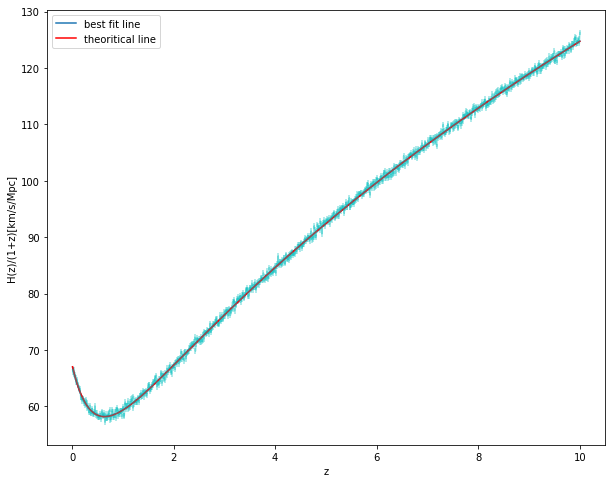

In [15]:
plt.figure(figsize=(10,8))
plt.errorbar(zs,H_zz,yerr=error_sigma,fmt='c',alpha=0.4)
bestOm1 = mi.params.valuesdict()['Om1']
bestH01 = mi.params.valuesdict()['H01']
bestw01 = mi.params.valuesdict()['w01']
plt.plot(zs,Hz1(zs,bestH01,bestOm1,bestw01)/(1+zs),'-',label="best fit line")
plt.plot(zs,Hz,'r',label="theoritical line")
plt.xlabel('z')
plt.ylabel('H(z)/(1+z)[km/s/Mpc]')
#plt.plot(zs,Hz-Hz1(zs,bestH01,bestOm1,bestw01),'r')
plt.legend(loc="upper left")
lmfit.report_fit(mi)


In [142]:
residuals=H_zz-Hz1(zs,bestH01,bestOm1,bestw01)/(1+zs)

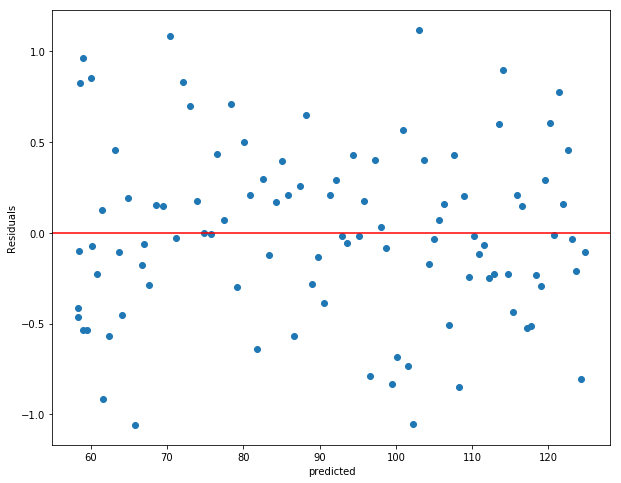

In [143]:
plt.figure(figsize=(10,8))
plt.plot(Hz1(zs,bestH01,bestOm1,bestw01)/(1+zs),residuals,'o')
plt.xlabel('predicted')
plt.ylabel('Residuals')
plt.axhline(y=0., color='r', linestyle='-')
plt.show()

In [16]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1500,thin=1,
                         params=p, is_weighted=True)

emcee: Exception while calling your likelihood function:
  params: [ 0.2789282  71.44364524]
  args: (<function residual at 0x7faab7be60c8>, Parameters([('Om1', <Parameter 'Om1', 0.27892820048777056, bounds=[0.0:2.0]>), ('H01', <Parameter 'H01', 71.44364523682212, bounds=[50.0:100.0]>), ('w01', <Parameter 'w01', value=-1.3 (fixed), bounds=[-3.0:-0.3]>)]), ['Om1', 'H01'], array([[  0.,   2.],
       [ 50., 100.]]))
  kwargs: {'nan_policy': 'omit', 'userkws': {}, 'userargs': [], 'is_weighted': True, 'float_behavior': 'posterior'}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/alexandra/.local/lib/python2.7/site-packages/lmfit/minimizer.py", line 2015, in _lnpost
    out = userfcn(params, *userargs, **userkwargs)
  File "<ipython-input-11-ecc0f7bf30ba>", line 8, in residual
    return (Hz1(zs,v['H01'],v['Om1'],v['w01'])/(1+zs)-H_zz)/error_sigma
  File "<ipython-input-3-86dec7f4795f>", line 2, in Hz1
    cosmo =FlatwCDM(H0=H01* u.km / u.s / u.Mpc, Om0=Om1,w0=w01)
  File "/home/alexandra/.local/lib/python2.7/site-packages/astropy/units/quantity.py", line 1080, in __div__
    return self.__truediv__(other)
  File "/home/alexandra/.local/lib/python2.7/site-packages/astropy/units/quantity.py", line 1055, in __truediv__
    return self._new_view(self.copy(), self.unit / other)
  File "/home/alexandra/.local/lib/python2.7/site-packages/astropy/units/core.py", line 663, in __div__
  

KeyboardInterrupt: 

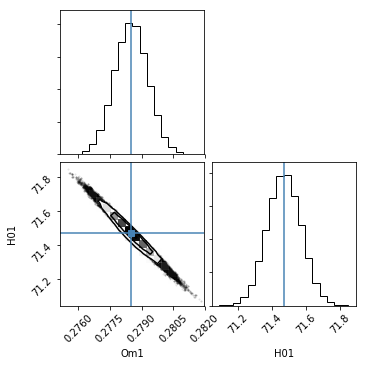

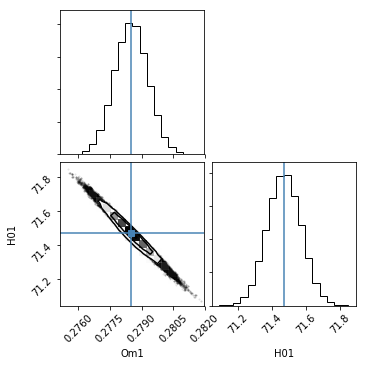

In [120]:
corner.corner(res.flatchain,labels=res.var_names, truths=list(res.params.valuesdict().values()))